In [1]:
import os
import tqdm.notebook
import torch
import botorch
import gpytorch
import numpy as np
import pyDOE2

import matplotlib
from matplotlib import pyplot as plt

import fbbo

In [2]:
# custom gpytorch fitting function so we can store visitied locations
from botorch.optim.utils import _scipy_objective_and_grad
from botorch.optim.numpy_converter import (
    module_to_array,
    set_params_with_array,
)
from typing import NamedTuple
import time
from gpytorch import settings as gpt_settings
from scipy.optimize import Bounds, minimize
import warnings
from botorch.exceptions.warnings import OptimizationWarning

class OptimizationIteration(NamedTuple):
    itr: int
    fun: float
    time: float
    x: np.ndarray


def fit_gpytorch_scipy(
    mll,
    bounds=None,
    method="L-BFGS-B",
    options=None,
    track_iterations=True,
    approx_mll=False,
    scipy_objective=_scipy_objective_and_grad,
    module_to_array_func=module_to_array,
    module_from_array_func=set_params_with_array,
):
    r"""Fit a gpytorch model by maximizing MLL with a scipy optimizer.
    The model and likelihood in mll must already be in train mode.
    This method requires that the model has `train_inputs` and `train_targets`.
    Args:
        mll: MarginalLogLikelihood to be maximized.
        bounds: A dictionary mapping parameter names to tuples of lower and upper
            bounds.
        method: Solver type, passed along to scipy.minimize.
        options: Dictionary of solver options, passed along to scipy.minimize.
        track_iterations: Track the function values and wall time for each
            iteration.
        approx_mll: If True, use gpytorch's approximate MLL computation. This is
            disabled by default since the stochasticity is an issue for
            determistic optimizers). Enabling this is only recommended when
            working with large training data sets (n>2000).
    Returns:
        2-element tuple containing
        - MarginalLogLikelihood with parameters optimized in-place.
        - Dictionary with the following key/values:
        "fopt": Best mll value.
        "wall_time": Wall time of fitting.
        "iterations": List of OptimizationIteration objects with information on each
        iteration. If track_iterations is False, will be empty.
        "OptimizeResult": The result returned by `scipy.optim.minimize`.
    Example:
        >>> gp = SingleTaskGP(train_X, train_Y)
        >>> mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        >>> mll.train()
        >>> fit_gpytorch_scipy(mll)
        >>> mll.eval()
    """
    options = options or {}
    x0, property_dict, bounds = module_to_array_func(
        module=mll, bounds=bounds, exclude=options.pop("exclude", None)
    )
    x0 = x0.astype(np.float64)
    if bounds is not None:
        bounds = Bounds(lb=bounds[0], ub=bounds[1], keep_feasible=True)

    xs = []
    ts = []
    t1 = time.time()

    def store_iteration(xk):
        xs.append(xk.copy())
        ts.append(time.time() - t1)
    
    cb = store_iteration if track_iterations else None

    with gpt_settings.fast_computations(log_prob=approx_mll):
        res = minimize(
            scipy_objective,
            x0,
            args=(mll, property_dict),
            bounds=bounds,
            method=method,
            jac=True,
            options=options,
            callback=cb,
        )
        iterations = []
        if track_iterations:
            for i, xk in enumerate(xs):
                obj, _ = scipy_objective(
                    x=xk, mll=mll, property_dict=property_dict
                )
                iterations.append(OptimizationIteration(i, obj, ts[i], xk))
    # Construct info dict
    info_dict = {
        "fopt": float(res.fun),
        "wall_time": time.time() - t1,
        "iterations": iterations,
        "OptimizeResult": res,
    }
    if not res.success:
        try:
            # Some res.message are bytes
            msg = res.message.decode("ascii")
        except AttributeError:
            # Others are str
            msg = res.message
        warnings.warn(
            f"Fitting failed with the optimizer reporting '{msg}'",
            OptimizationWarning,
        )
    # Set to optimum
    mll = module_from_array_func(mll, res.x, property_dict)
    return mll, info_dict

# Marginal likelihood plot
recreate the GPML book plot showing a gp model a ML landscape with two+ local maxima and plots of the GP at the maxima

In [3]:
class GP_FixedNoise(
    gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel
):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(
        self, train_x, train_y, ls_prior, os_prior, noise_prior, ARD=False
    ):

        likelihood = gpytorch.likelihoods.GaussianLikelihood(
            noise_prior=noise_prior,
        )
        super(GP_FixedNoise, self).__init__(train_x, train_y, likelihood)

        base_kernel = gpytorch.kernels.MaternKernel(
            lengthscale_prior=ls_prior,
            nu=5 / 2,
            ard_num_dims=train_x.shape[-1] if ARD else None,
        )

        self.covar_module = gpytorch.kernels.ScaleKernel(
            base_kernel, outputscale_prior=os_prior,
        )
        self.mean_module = gpytorch.means.ZeroMean()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    def set_params(self, ls=None, os=None, noise=None):
        if ls is not None:
            self.covar_module.base_kernel.lengthscale = ls
        if os is not None:
            self.covar_module.outputscale = os
        if noise is not None:
            self.likelihood.noise = noise


def model_fit(mll):
    mll.train()
    output = mll.model(*mll.model.train_inputs)
    qual = mll(output, mll.model.train_targets)
    return qual.sum().item()

In [4]:
def convert_params(model, ls, os):
    return np.array(
        [
            model.covar_module.base_kernel.raw_lengthscale_constraint.transform(
                torch.tensor(ls)
            ),
            model.covar_module.raw_outputscale_constraint.transform(
                torch.tensor(os)
            ),
        ]
    )

In [5]:
# ---- settings
# prior bounds
ls_bounds = [-2, 2]
os_bounds = [-2, 2]
noise_bounds = [-6, 6]

# plotting bounds
xbounds = np.array([-5.0, 5.0])
ybounds = np.array([-3.0, 3.0])

ls_prior = gpytorch.priors.torch_priors.UniformPrior(
    *np.power(10.0, ls_bounds)
)  # ell
os_prior = gpytorch.priors.torch_priors.UniformPrior(
    *np.power(10.0, os_bounds)
)  # sigma_f
noise_prior = gpytorch.priors.torch_priors.UniformPrior(
    *np.power(10.0, noise_bounds)
)  # sigma_n


problem_dim = 8

In [6]:
seed = 4 # 8 in 1d
n_train = 17

torch.manual_seed(seed)
np.random.seed(seed)

# make a gp with no data (for use in prior mode)
prior_model = GP_FixedNoise(None, None, ls_prior, os_prior, noise_prior)

FIXED_NOISE = 0.1

# set the GP hyperparams like in the book
prior_model.set_params(ls=1., os=1., noise=FIXED_NOISE)

# get the model ready to sample
prior_model.eval()
X = torch.rand(n_train,  problem_dim).reshape(n_train, problem_dim)
with torch.no_grad():
    y_base = prior_model(X)

# draw a realisation
y = y_base.sample()
y += torch.randn_like(y) * prior_model.likelihood.noise.sqrt().item()

if problem_dim == 1:
    fig, ax = plt.subplots(1, 1, figsize=(10, 4))
    ax.plot(X, y, "ro")
    ax.set_xlim(xbounds)
    ax.set_ylim(ybounds)
    plt.show()
    
X.shape, y.shape

(torch.Size([17, 8]), torch.Size([17]))

In [7]:
ls_prior._validate_args = False
os_prior._validate_args = False

In [8]:
# new model with the drawn data
model = GP_FixedNoise(X, y, ls_prior, os_prior, noise_prior)
model.set_params(ls=1.0, os=1.0, noise=FIXED_NOISE)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

start_locs = []
end_locs = []
losses = []
xs = []

model = GP_FixedNoise(X, y, ls_prior, os_prior, noise_prior)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

# set model params to the fixed noise value
model.set_params(noise=FIXED_NOISE)

# turn off optimisation of the noise
model.likelihood.raw_noise.requires_grad = False

n = 3

LS = np.logspace(ls_bounds[0] + 0.2, ls_bounds[1] - 0.2, n, endpoint=True)
OS = np.logspace(os_bounds[0] + 0.2, os_bounds[1] - 0.2, n, endpoint=True)
P = np.vstack([_.ravel() for _ in np.meshgrid(LS, OS)]).T

with tqdm.notebook.tqdm(total=n ** 2) as pbar:
    for ls in LS:
        for oss in OS:
            # set the params
            model.set_params(ls=ls, os=oss, noise=FIXED_NOISE)

            # optimise
            _, res = fit_gpytorch_scipy(
                mll, method="L-BFGS-B", track_iterations=True
            )

            # get each location visited.
            # x is stored as [os, ls] so reverse it for conversion
            visited_locs = np.array(
                [
                    convert_params(model, ls=it.x[1], os=it.x[0])
                    for it in res["iterations"]
                ]
            )

            # store it all
            start_locs.append([ls, oss])
            if visited_locs.shape[0] == 0:
                end_locs.append([ls, oss])
            else:
                end_locs.append(visited_locs[-1])
            losses.append(res["fopt"])
            xs.append(visited_locs)

            pbar.update()

  0%|          | 0/9 [00:00<?, ?it/s]

In [9]:
# convert to arrays and sort by loss (largest first)
start_locs = np.array(start_locs)
end_locs = np.array(end_locs)
losses = np.array(losses)
inds = np.argsort(losses)[::-1]
start_locs = start_locs[inds]
end_locs = end_locs[inds]
losses = losses[inds]
xs = [xs[i] for i in inds]

In [10]:
if problem_dim == 1: 
    xx = torch.linspace(*xbounds, 1000).reshape(-1, 1)

    for (ls, oss), l, xvals in zip(end_locs, losses, xs):
        if not np.isfinite(l):
            continue

        print(xvals.shape[0], l)
        print('LS:', ls, 'OS:', oss)

        model = GP_FixedNoise(X, y, ls_prior, os_prior, noise_prior)
        model.eval()
        model.set_params(ls=ls, os=oss, noise=FIXED_NOISE)

        with torch.no_grad():
            observed_pred = model.posterior(xx)
            mu = observed_pred.mean.numpy()
            lower, upper = observed_pred.mvn.confidence_region()

        fig, ax = plt.subplots(1,1,figsize=(10, 4))
        ax.plot(xx, mu)
        ax.plot(X, y, 'ro')

        ax.fill_between(xx.numpy().ravel(), lower, upper, alpha=0.25)

        ax.set_xlim(xbounds)
        ax.set_ylim(ybounds)
        plt.show()

In [11]:
# evaluate hyperparams
n = 50

p0 = np.logspace(*ls_bounds, n, endpoint=True)
p1 = np.logspace(*os_bounds, n, endpoint=True)
P = np.vstack([_.ravel() for _ in np.meshgrid(p0, p1)]).T
res = np.zeros(n**2)

# new model with the drawn data
model = GP_FixedNoise(X, y, ls_prior, os_prior, noise_prior)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)

for i in tqdm.notebook.tqdm(range(n**2)):
    with torch.no_grad():
        model.set_params(ls=P[i, 0], os=P[i, 1], noise=FIXED_NOISE)
        res[i] = model_fit(mll)

  0%|          | 0/2500 [00:00<?, ?it/s]

In [21]:
save_images = True

# default settings
plt.rcParams['figure.dpi'] = 200 # 200 at (6, 3) is size (1200 x 600 pixels)
plt.rcParams['figure.figsize'] = [6, 3]
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.transparent'] = True

if save_images:
    # configure matplotlib to use latex so we're able to use the libertine font
    plt.rcParams["text.usetex"] = True
    plt.rcParams[
        "text.latex.preamble"
    ] = r"""
\usepackage{libertine}
\usepackage[libertine]{newtxmath}
\usepackage{sfmath}
\usepackage[T1]{fontenc}
"""

    import matplotlib

    matplotlib.rcParams["pdf.fonttype"] = 42
    matplotlib.rcParams["ps.fonttype"] = 42
    matplotlib.rcParams["backend"] = "pdf"
else:
    plt.rcParams["text.usetex"] = False

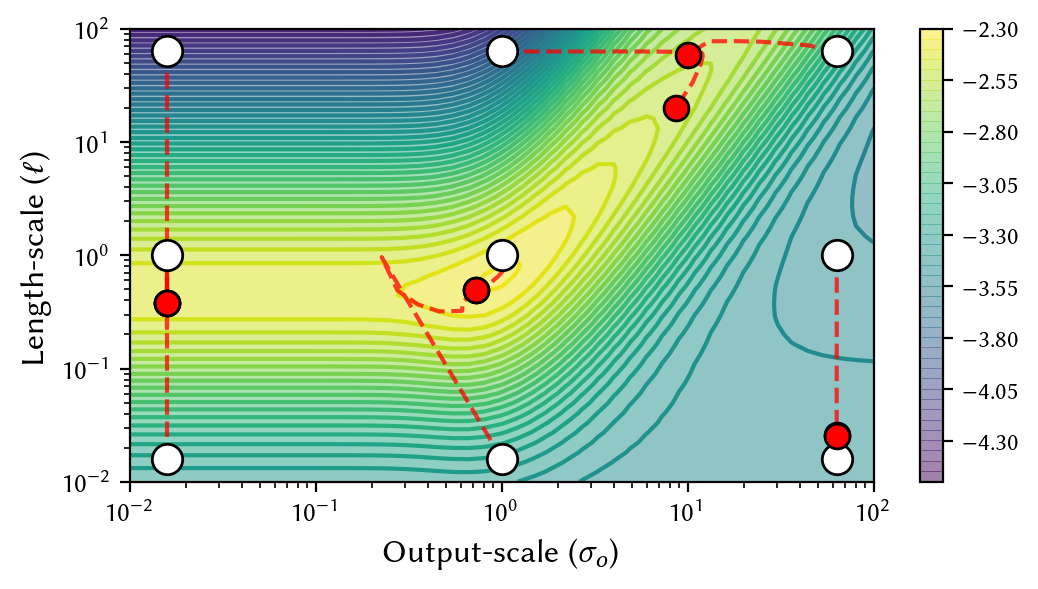

In [22]:
res = res.reshape(n, n)

cmap = matplotlib.cm.viridis
nlevels = 50

p0 = np.logspace(ls_bounds[0], ls_bounds[1] + 0.25, n, endpoint=True)
p1 = np.logspace(os_bounds[0], os_bounds[1] + 0.25, n, endpoint=True)

fig, ax = plt.subplots(1, 1)
# c = ax.pcolormesh(p0, p1, res, shading="gouraud", zorder=-1)
c = ax.contour(
    p0, p1, res, levels=nlevels, cmap=cmap, linewidths=1.5, zorder=0
)
c = ax.contourf(p0, p1, res, levels=nlevels, alpha=0.5, cmap=cmap, zorder=-1)

for sl, el, loss, locs in zip(start_locs, end_locs, losses, xs):
    ax.scatter(
        sl[0], sl[1], s=120, marker="o", c="w", edgecolor="k", zorder=1
    )  # start

    z0 = [sl[0]]
    z1 = [sl[1]]
    if locs.shape[0] > 0:
        z0 += [*locs[:, 0]]
        z1 += [*locs[:, 1]]

    ax.plot(z0, z1, "r--", alpha=0.75, zorder=0)

    ax.scatter(
        el[0], el[1], s=80, marker="o", c="r", edgecolor="k", zorder=1,
    )

ax.loglog()

ax.set_xlabel("Output-scale ($\sigma_o$)", fontsize=12)
ax.set_ylabel("Length-scale ($\ell$)", fontsize=12)

cb = plt.colorbar(c)
cb.ax.tick_params(labelsize=9)
ax.set_xlim(np.power(10.0, ls_bounds))
ax.set_ylim(np.power(10.0, os_bounds))

plt.savefig("likelihood_optimisation.pdf", bbox_inches="tight")
plt.show()